In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.head(2)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...


# 2.1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

/home/dxlab/jupyter/envs/sum_py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

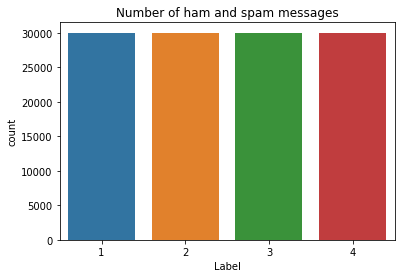

In [4]:
sns.countplot(train['Class Index'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

## 전처리

In [5]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to /home/dxlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [7]:
def preprocess(text, stem=False):
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
train['Description'] = train['Description'].apply(lambda x: preprocess(x))

In [9]:
test['Description'] = test['Description'].apply(lambda x: preprocess(x))

In [10]:
train.drop_duplicates(subset = ['Description'], inplace=True)
train = train.dropna(how='any')
print('train :',len(train))

train : 118341


In [11]:
test.drop_duplicates(subset = ['Description'], inplace=True)
test = test.dropna(how='any')
print('test :',len(test))

test : 7591


## Tokenizing

In [12]:
MAX_NB_WORDS = 60000
MAX_SEQUENCE_LENGTH = 50

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token = '<OOV>')
tokenizer.fit_on_texts(train['Description'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 60514


In [113]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'new': 3,
 'us': 4,
 'reuters': 5,
 'ap': 6,
 'two': 7,
 'first': 8,
 'monday': 9,
 'wednesday': 10}

In [14]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train['Description']),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test['Description']),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (118341, 50)
Testing X Shape: (7591, 50)


In [15]:
labels = train['Class Index'].unique().tolist()

## Label Encoding

In [16]:
encoder = LabelEncoder()
encoder.fit(train['Class Index'].to_list())

y_train = encoder.transform(train['Class Index'].to_list())
y_test = encoder.transform(test['Class Index'].to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (118341, 1)
y_test shape: (7591, 1)


# 2.2

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate

In [21]:
EMBEDDING_DIM = 300
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          18000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 18,161,713
Trainable params: 18,161,713
Non-trainable params: 0
_________________________________________________________________


In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/10
1578/1578 [==============================] - ETA: 0s - loss: 0.4108 - acc: 0.8530WARNING:tensorflow:Model was constructed with shape (None, 100) for input Tensor("embedding_1_input:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 50).

Epoch 00001: val_acc improved from -inf to 0.90105, saving model to best_model.h5
1578/1578 [==============================] - 302s 192ms/step - loss: 0.4108 - acc: 0.8530 - val_loss: 0.2934 - val_acc: 0.9011
Epoch 2/10
1578/1578 [==============================] - ETA: 0s - loss: 0.1888 - acc: 0.9370
Epoch 00002: val_acc did not improve from 0.90105
1578/1578 [==============================] - 249s 158ms/step - loss: 0.1888 - acc: 0.9370 - val_loss: 0.3033 - val_acc: 0.8961
Epoch 3/10
1578/1578 [==============================] - ETA: 0s - loss: 0.1212 - acc: 0.9591
Epoch 00003: val_acc did not improve from 0.90105
1578/1578 [==============================] - 202s 128ms/step - loss: 0.1212 - ac

In [86]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

238/238 [==============================] - 2s 8ms/step - loss: 0.3752 - acc: 0.8963
Test set
  Loss: 0.375
  Accuracy: 0.896


# 2.3

In [87]:
train.head(2)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),reuters shortsellers wall streets dwindlingban...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,reuters private investment firm carlyle groupw...


In [31]:
sentences_t = []
words_t = []

train = train.reset_index()

for i in range(len(train)):
    sentences_t.append(str(train['Description'][i]))
    words_t.append(sentences_t[i].split(' '))
len(words_t)

118341

In [25]:
from gensim.models.word2vec import Word2Vec

In [29]:

# 단어를 벡터화할 때 단어의 문맥적 의미를 보존

# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수 어휘의 크기를 의미있는 단어로 제한하는 데 도움이 된다. 
num_workers = 4 # 병렬 처리 스레드 수 CPU 쿼드코어
context = 10 # 주변단어 앞뒤로 10개
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(words_t, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling,
                          sg=1)
model

In [30]:
model.save('word2vec.model')

In [26]:
w2v_model = Word2Vec.load('word2vec.model')

In [19]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Description'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 60513


In [23]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train['Description']),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test['Description']),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (118341, 50)
Testing X Shape: (7591, 50)


In [27]:
import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 300차원 vector를 가져옵니다
for word, idx in tokenizer.word_index.items():
    embedding_vector = w2v_model[word] if word in w2v_model else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
embedding_matrix.shape

/home/dxlab/jupyter/envs/sum_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/dxlab/jupyter/envs/sum_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


(60513, 300)

In [31]:
EMBEDDING_DIM = 300
model = Sequential()
model.add(Embedding(VOCAB_SIZE,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           18153900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 13)                1313      
Total params: 18,315,613
Trainable params: 161,713
Non-trainable params: 18,153,900
_________________________________________________________________


In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [37]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/10
1578/1578 [==============================] - ETA: 0s - loss: 0.3679 - acc: 0.8744
Epoch 00001: val_acc improved from -inf to 0.89222, saving model to best_model.h5
1578/1578 [==============================] - 91s 58ms/step - loss: 0.3679 - acc: 0.8744 - val_loss: 0.2968 - val_acc: 0.8922
Epoch 2/10
1578/1578 [==============================] - ETA: 0s - loss: 0.2961 - acc: 0.8962
Epoch 00002: val_acc improved from 0.89222 to 0.90435, saving model to best_model.h5
1578/1578 [==============================] - 91s 57ms/step - loss: 0.2961 - acc: 0.8962 - val_loss: 0.2673 - val_acc: 0.9043
Epoch 3/10
1578/1578 [==============================] - ETA: 0s - loss: 0.2685 - acc: 0.9039
Epoch 00003: val_acc did not improve from 0.90435
1578/1578 [==============================] - 90s 57ms/step - loss: 0.2685 - acc: 0.9039 - val_loss: 0.2804 - val_acc: 0.8950
Epoch 4/10
1578/1578 [==============================] - ETA: 0s - loss: 0.2503 - acc: 0.9102
Epoch 00004: val_acc improved from 0

In [39]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

238/238 [==============================] - 2s 8ms/step - loss: 0.2443 - acc: 0.9169
Test set
  Loss: 0.244
  Accuracy: 0.917


# 2.4

In [34]:
from gensim.models import FastText

ft_model = FastText(words_t, size=300, window=5, min_count=5, workers=4, sg=1)

In [35]:
import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 300차원 vector를 가져옵니다
for word, idx in tokenizer.word_index.items():
    embedding_vector = ft_model[word] if word in ft_model else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
embedding_matrix.shape

/home/dxlab/jupyter/envs/sum_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/dxlab/jupyter/envs/sum_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


(60514, 300)

In [36]:
EMBEDDING_DIM = 300
model = Sequential()
model.add(Embedding(VOCAB_SIZE,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           18154200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1313      
Total params: 18,315,913
Trainable params: 161,713
Non-trainable params: 18,154,200
_________________________________________________________________


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/10
1577/1578 [============================>.] - ETA: 0s - loss: 0.3712 - acc: 0.8729
Epoch 00001: val_acc did not improve from 0.90105
1578/1578 [==============================] - 61s 39ms/step - loss: 0.3713 - acc: 0.8729 - val_loss: 0.2842 - val_acc: 0.8964
Epoch 2/10
1577/1578 [============================>.] - ETA: 0s - loss: 0.2949 - acc: 0.8961
Epoch 00002: val_acc improved from 0.90105 to 0.90219, saving model to best_model.h5
1578/1578 [==============================] - 62s 39ms/step - loss: 0.2949 - acc: 0.8961 - val_loss: 0.2675 - val_acc: 0.9022
Epoch 3/10
1577/1578 [============================>.] - ETA: 0s - loss: 0.2684 - acc: 0.9047
Epoch 00003: val_acc improved from 0.90219 to 0.90595, saving model to best_model.h5
1578/1578 [==============================] - 61s 39ms/step - loss: 0.2684 - acc: 0.9047 - val_loss: 0.2554 - val_acc: 0.9060
Epoch 4/10
1577/1578 [============================>.] - ETA: 0s - loss: 0.2488 - acc: 0.9110
Epoch 00004: val_acc improved fro

In [39]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

238/238 [==============================] - 1s 5ms/step - loss: 0.2431 - acc: 0.9161
Test set
  Loss: 0.243
  Accuracy: 0.916
